<a href="https://colab.research.google.com/github/pavithrasenth/Hand_Detection/blob/main/lastname.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [3]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv("medium_articles.csv")
texts = df['text'].dropna().tolist()

Saving medium_articles.csv to medium_articles.csv


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

sentences = []
for t in texts[:5000]:
    for s in t.split("."):
        s = clean_text(s).strip()
        if len(s.split()):
            sentences.append(s)

In [5]:
all_words = [word for s in sentences for word in s.split()]
word_counts = Counter(all_words)
vocab = {w: i+2 for i, (w, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1
inv_vocab = {i:w for w,i in vocab.items()}

def encode_sentence(sentence):
    return [vocab.get(w, 1) for w in sentence.split()]


In [6]:
class TextDataset(Dataset):
    def __init__(self, sentences, vocab, max_len=20):
        self.vocab = vocab
        self.max_len = max_len
        self.data = []
        for s in sentences:
            words = encode_sentence(s)
            if len(words) < 2:
                continue
            input_seq = words[:-1]
            target = words[-1]
            if len(input_seq) < max_len:
                input_seq = [0]*(max_len-len(input_seq)) + input_seq
            else:
                input_seq = input_seq[-max_len:]
            self.data.append((input_seq, target))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx][0]), torch.tensor(self.data[idx][1])

dataset = TextDataset(sentences, vocab)
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=42)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        out, (h, c) = self.lstm(embedded)
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(len(vocab), embed_size=128, hidden_size=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 5
train_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.7473
Epoch 2/5, Loss: 0.4018
Epoch 3/5, Loss: 0.2118
Epoch 4/5, Loss: 0.1192
Epoch 5/5, Loss: 0.0751


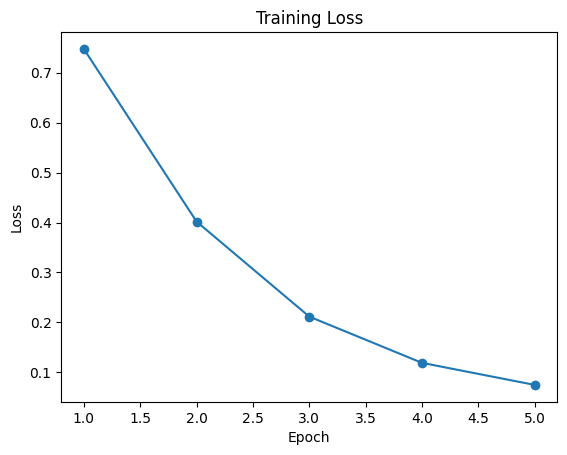

In [10]:
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [11]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")

Test Accuracy: 61.71%


In [12]:
def predict_last_word(sentence, max_len=20):
    model.eval()
    words = encode_sentence(clean_text(sentence))
    if len(words) < max_len:
        words = [0]*(max_len-len(words)) + words
    else:
        words = words[-max_len:]
    inp = torch.tensor([words]).to(device)
    with torch.no_grad():
        output = model(inp)
        _, predicted = torch.max(output, 1)
    return inv_vocab.get(predicted.item(), "<UNK>")

In [13]:
examples = [
    "Deep learning is very",
    "The quick brown fox jumps over the lazy",
    "Artificial intelligence will change the"
]
for ex in examples:
    print(f"Input: {ex}")
    print(f"Predicted last word: {predict_last_word(ex)}\n")

Input: Deep learning is very
Predicted last word: fast

Input: The quick brown fox jumps over the lazy
Predicted last word: gan

Input: Artificial intelligence will change the
Predicted last word: world

